Class distribution: {'avocado_toast': 158, 'tuna_salad': 169, 'smoothie_bowl': 56, 'roasted_vegetables': 106, 'oatmeal': 173, 'boiled_eggs': 179, 'quinoa_salad': 77, 'fruit_salad': 69, 'vegetable_salad': 158, 'grilled_chicken_breast': 140, 'steamed_tempeh': 110, 'steamed_tofu': 173}


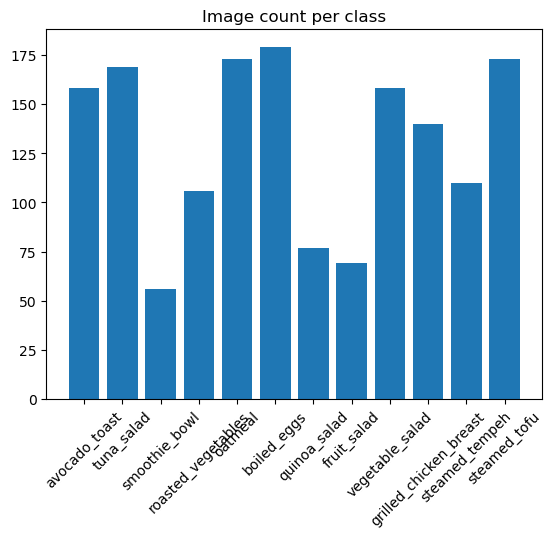

Found 1568 files belonging to 12 classes.
Using 1255 files for training.
Found 1568 files belonging to 12 classes.
Using 313 files for validation.


2025-08-08 15:24:19.696856: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-08 15:24:19.696908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-08 15:24:19.696918: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-08 15:24:19.697169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-08 15:24:19.697181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Class weights: {0: 0.823490813648294, 1: 0.6835511982570807, 2: 1.9367283950617284, 3: 1.0354785478547854, 4: 0.7578502415458938, 5: 1.71448087431694, 6: 1.2450396825396826, 7: 2.1788194444444446, 8: 1.1492673992673992, 9: 0.7746913580246914, 10: 0.7804726368159204, 11: 0.8107235142118863}


2025-08-08 15:24:20.191617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.applications import resnet50, efficientnet, mobilenet_v2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set paths
DATASET_DIR = "/Users/shrutikagupta/Desktop/Datasets/NNDL_Datasets/healthy food/train"  # Replace with your dataset folder path

# Count images per class
def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images
    return class_counts

class_counts = count_images_per_class(DATASET_DIR)
print("Class distribution:", class_counts)

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Image count per class")
plt.show()

# Load dataset
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(DATASET_DIR, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset='training', seed=123)
val_ds = image_dataset_from_directory(DATASET_DIR, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset='validation', seed=123)

class_names = train_ds.class_names
num_classes = len(class_names)

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Compute class weights to handle imbalance
labels = []
for _, y in train_ds.unbatch():
    labels.append(int(y))
labels = np.array(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


In [3]:
def build_basic_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

basic_model = build_basic_cnn((224, 224, 3), num_classes)
basic_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_basic = basic_model.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights)


Epoch 1/10


2025-08-08 15:24:38.097418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.0986 - loss: 2.4390 - val_accuracy: 0.1150 - val_loss: 2.4688
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.1364 - loss: 2.4000 - val_accuracy: 0.1406 - val_loss: 2.3783
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.1136 - loss: 2.3573 - val_accuracy: 0.1853 - val_loss: 2.3501
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.1811 - loss: 2.2895 - val_accuracy: 0.1917 - val_loss: 2.3034
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.1768 - loss: 2.2443 - val_accuracy: 0.1821 - val_loss: 2.2806
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.1939 - loss: 2.1783 - val_accuracy: 0.2460 - val_loss: 2.2209
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.2289 - loss: 2.1430 - val_accuracy: 0.2396 - val_loss: 2.1573
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.2364 - loss: 2.1076 - val_accuracy: 0.2109 - val_

In [5]:
def build_transfer_model(base_model_class, preprocess_fn, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = preprocess_fn(inputs)  # << THIS IS CRUCIAL
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)
    
models_dict = {
    "ResNet50": (ResNet50, resnet50.preprocess_input),
    "EfficientNetB0": (EfficientNetB0, efficientnet.preprocess_input),
    "MobileNetV2": (MobileNetV2, mobilenet_v2.preprocess_input)
}

histories = {}  # Initialize the dictionary
trained_models = {} 

for name, (model_class, preprocess_fn) in models_dict.items():
    print(f"\nTraining {name}...")
    model = build_transfer_model(model_class, preprocess_fn, (224, 224, 3), num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights)
    histories[name] = history              # Save training history
    trained_models[name] = model           # Save trained model itself


Training ResNet50...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 509ms/step - accuracy: 0.2315 - loss: 2.6365 - val_accuracy: 0.6262 - val_loss: 1.2360
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.6704 - loss: 1.0038 - val_accuracy: 0.7125 - val_loss: 0.9604
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 431ms/step - accuracy: 0.7605 - loss: 0.6931 - val_accuracy: 0.7476 - val_loss: 0.8393
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.8408 - loss: 0.4971 - val_accuracy: 0.7508 - val_loss: 0.8162
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 431ms/step - accuracy: 0.8618 - loss: 0.4247 - val_accuracy: 0.7316 - val_loss: 0.8472
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.8809 - loss: 0.4074 - val_accuracy: 0.7700 - val_loss: 0.7818
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - accuracy: 0.9018 - loss: 0.3207 - val_accuracy: 0.7540 - val_loss: 0.7786
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - accuracy: 0.9001 - l

In [7]:
histories["Basic CNN"] = history_basic

In [9]:
def evaluate_model_simple(model, train_ds, val_ds, class_names, title="Model"):
    print(f"\n📊 {title} Evaluation")
    print("=" * (len(title) + 15))

    # Final train metrics
    train_loss, train_acc = model.evaluate(train_ds, verbose=0)
    print(f"Train Accuracy:    {train_acc:.4f}")
    print(f"Train Loss:        {train_loss:.4f}")

    # Final val metrics
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Loss:     {val_loss:.4f}")

    # Precision, Recall, F1
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [11]:
evaluate_model_simple(basic_model, train_ds, val_ds, class_names, title="Basic CNN")
evaluate_model_simple(trained_models["ResNet50"], train_ds, val_ds, class_names, title="ResNet50")
evaluate_model_simple(trained_models["EfficientNetB0"], train_ds, val_ds, class_names, title="EfficientNetB0")
evaluate_model_simple(trained_models["MobileNetV2"], train_ds, val_ds, class_names, title="MobileNetV2")


📊 Basic CNN Evaluation
Train Accuracy:    0.1777
Train Loss:        2.4119
Validation Accuracy: 0.1885
Validation Loss:     2.4660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

Classification Report:
                        precision    recall  f1-score   support

         avocado_toast     0.0000    0.0000    0.0000        31
           boiled_eggs     0.8000    0.1538    0.2581        26
           fruit_salad     0.0000    0.0000    0.0000        15
grilled_chicken_breast     0.0000    0.0000    0.0000        39
               oatmeal     0.7143    0.1429    0.2381        35
          quinoa_salad     0.1562    0.9375    0.2679        16
    roasted_ve

2025-08-08 15:33:41.620199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Accuracy:    0.9761
Train Loss:        0.1483
Validation Accuracy: 0.8051
Validation Loss:     0.7353
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
                        precision    recall  f1-score   support

         avocado_toast     0.8788    0.9355    0.9062        31
           boiled_eggs     1.0000    0.9231    0.9600        26
           fruit_salad     0.6316    0.8000    0.7059        15
grilled_chicken_breast     0.8780    0.9231    0.9000        39
               oatmeal     0.8571    0.8571    0.8571        35
          quinoa_salad     0.7500    0.7500    0.7500        16
    roasted_vegetables     0.7037  

2025-08-08 15:34:09.295555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Accuracy:    0.9339
Train Loss:        0.2977
Validation Accuracy: 0.8211
Validation Loss:     0.6269
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:
                        precision    recall  f1-score   support

         avocado_toast     0.7632    0.9355    0.8406        31
           boiled_eggs     1.0000    0.9231    0.9600        26
           fruit_salad     0.7778    0.9333    0.8485        15
grilled_chicken_breast     0.9211    0.8974    0.9091        39
               oatmeal     0.9143    0.9143    0.9143        35
          quinoa_salad     0.6667    0.8750    0.7568        16
    roasted_vegetables     0.8571  

2025-08-08 15:34:34.747180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Accuracy:    0.9363
Train Loss:        0.2908
Validation Accuracy: 0.7252
Validation Loss:     0.8189
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:
                        precision    recall  f1-score   support

         avocado_toast     0.8235    0.9032    0.8615        31
           boiled_eggs     0.9600    0.9231    0.9412        26
           fruit_salad     0.6500    0.8667    0.7429        15
grilled_chicken_breast     0.8750    0.8974    0.8861        39
               oatmeal     0.8696    0.5714    0.6897        35
          quinoa_salad     0.6667    0.8750    0.7568        16
    roasted_vegetables     0.7826  

2025-08-08 15:34:50.295700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


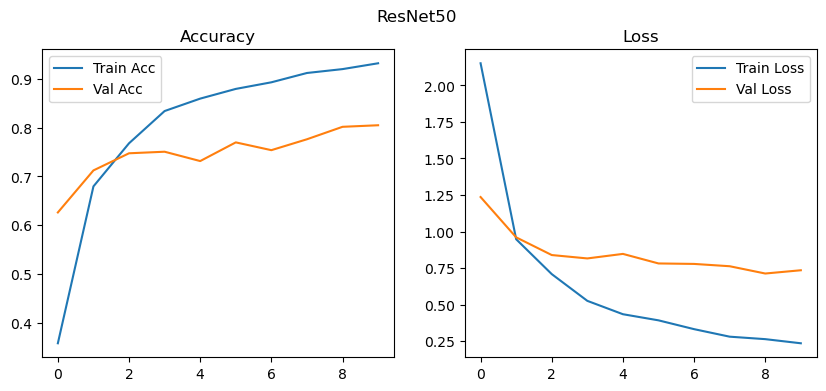

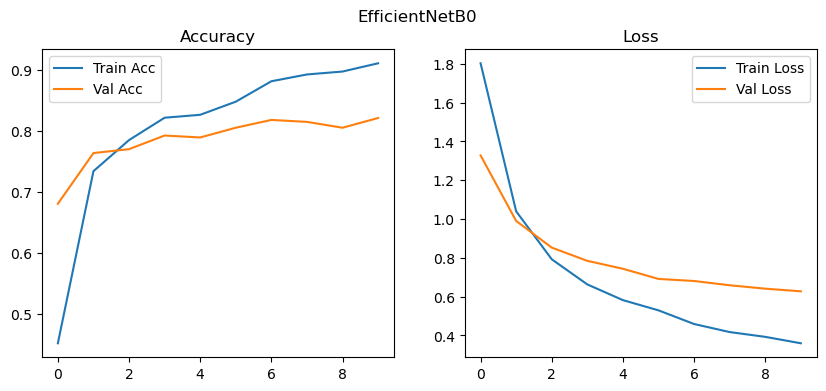

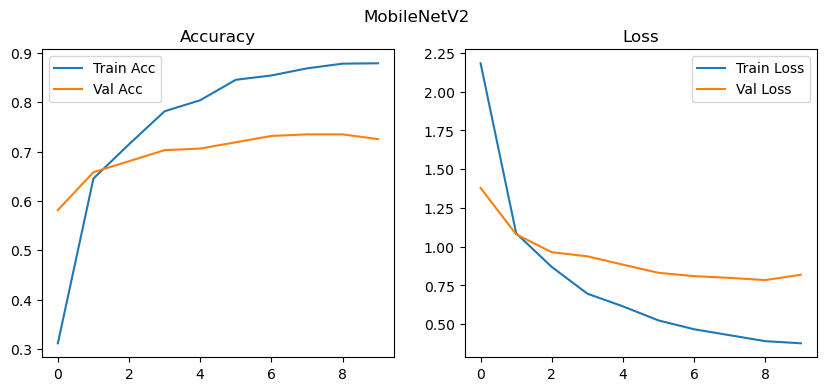

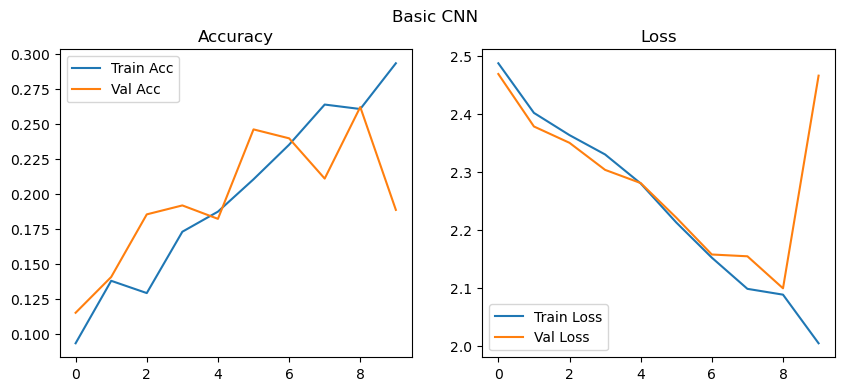

In [13]:
def plot_metrics(histories):
    for name, hist in histories.items():
        plt.figure(figsize=(10, 4))
        plt.suptitle(name)
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label='Train Acc')
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy')
        plt.legend()
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.show()

plot_metrics(histories)



🔍 Confusion Matrix for Basic CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


2025-08-08 15:35:52.387243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


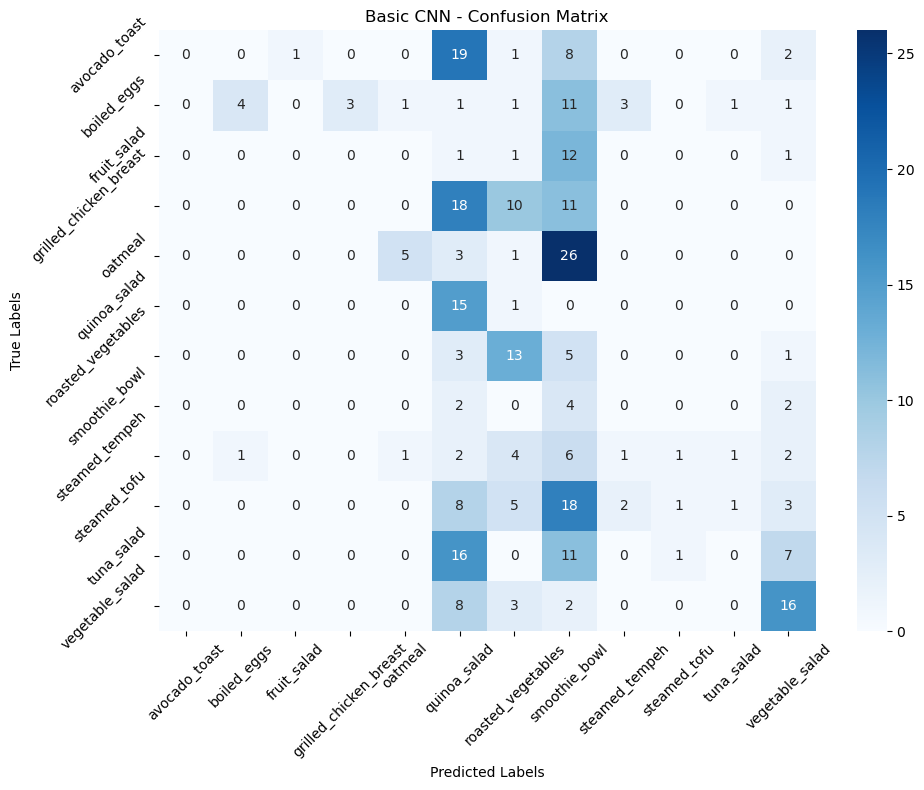


🔍 Confusion Matrix for ResNet50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-08-08 15:35:58.508137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


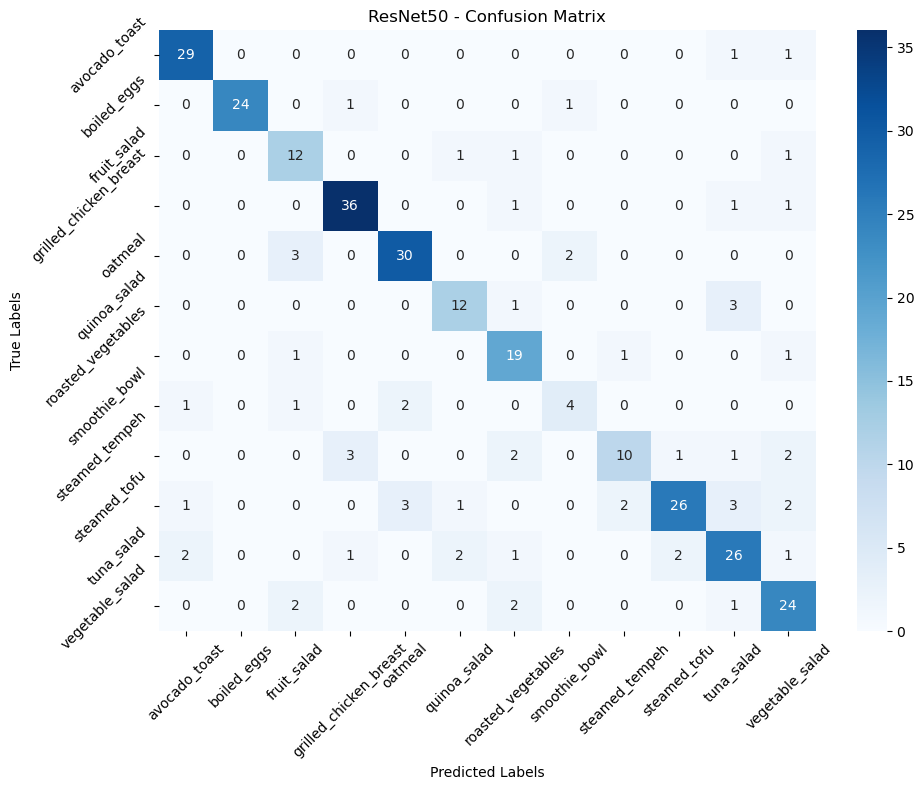


🔍 Confusion Matrix for EfficientNetB0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


2025-08-08 15:36:04.777054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


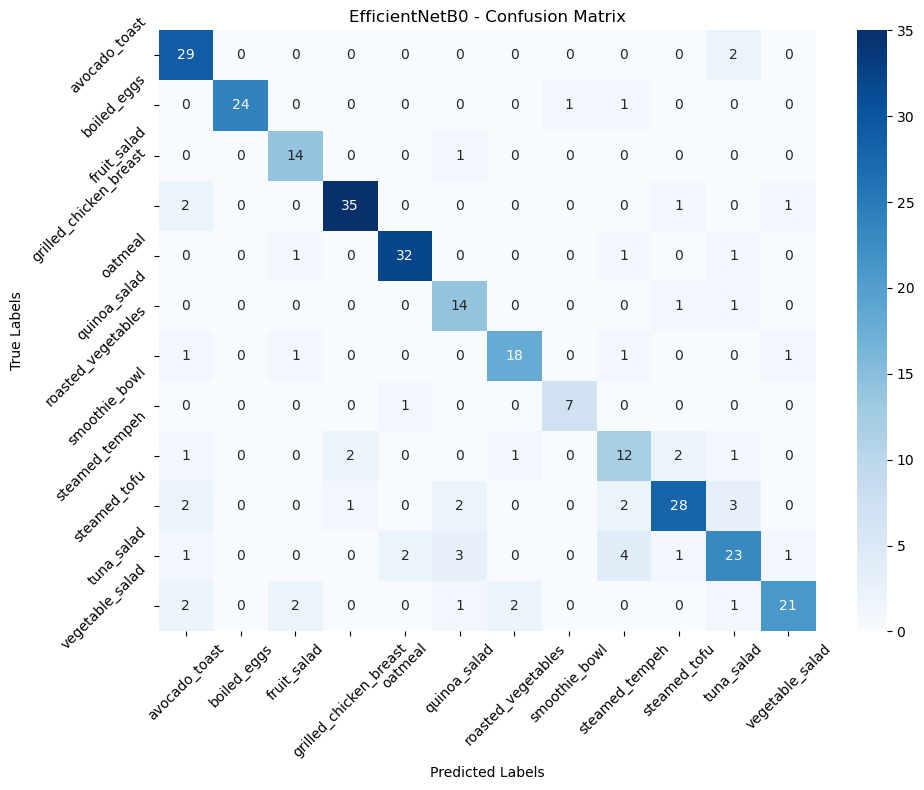


🔍 Confusion Matrix for MobileNetV2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


2025-08-08 15:36:08.140630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


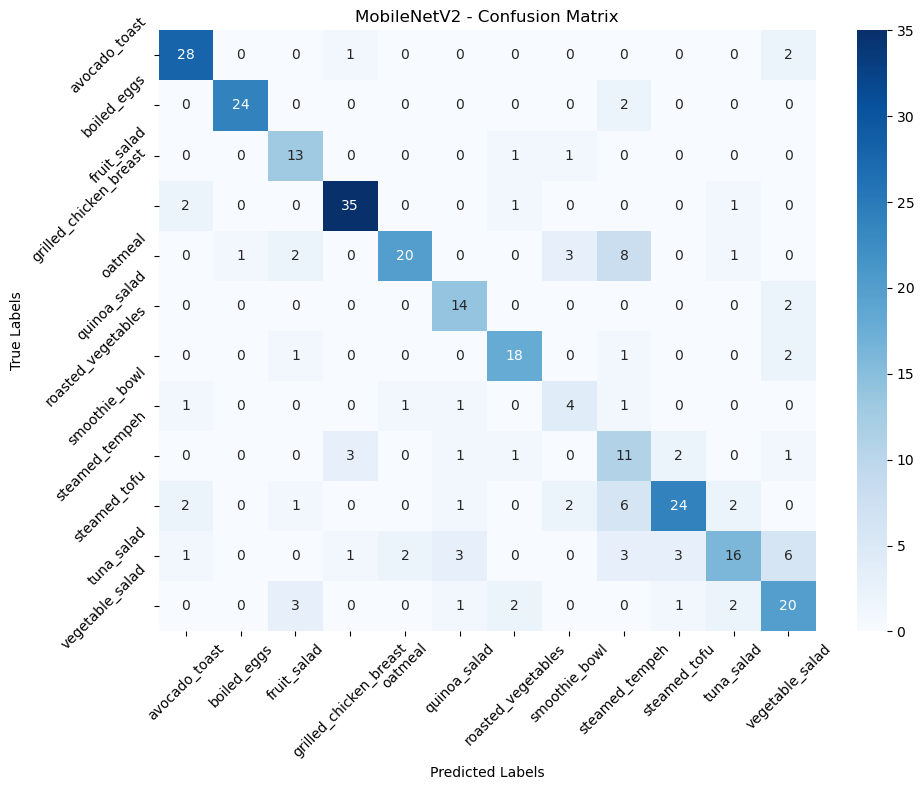

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Combine all models into one dictionary
all_models = {
    "Basic CNN": basic_model,
    "ResNet50": trained_models["ResNet50"],
    "EfficientNetB0": trained_models["EfficientNetB0"],
    "MobileNetV2": trained_models["MobileNetV2"]
}

# Plot confusion matrix for each model
for name, model in all_models.items():
    print(f"\n🔍 Confusion Matrix for {name}")
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [19]:
# Visualization function
def visualize_predictions(model, dataset, class_names, num_images=9, title="Model"):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Predictions from {title}", fontsize=16)
    for images, labels in dataset.take(1):
        preds = model.predict(images[:num_images])
        pred_classes = np.argmax(preds, axis=1)
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}")
            plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leaves space for suptitle
    plt.show()

# Set input shape
input_shape = (224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


2025-08-08 15:37:06.778633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


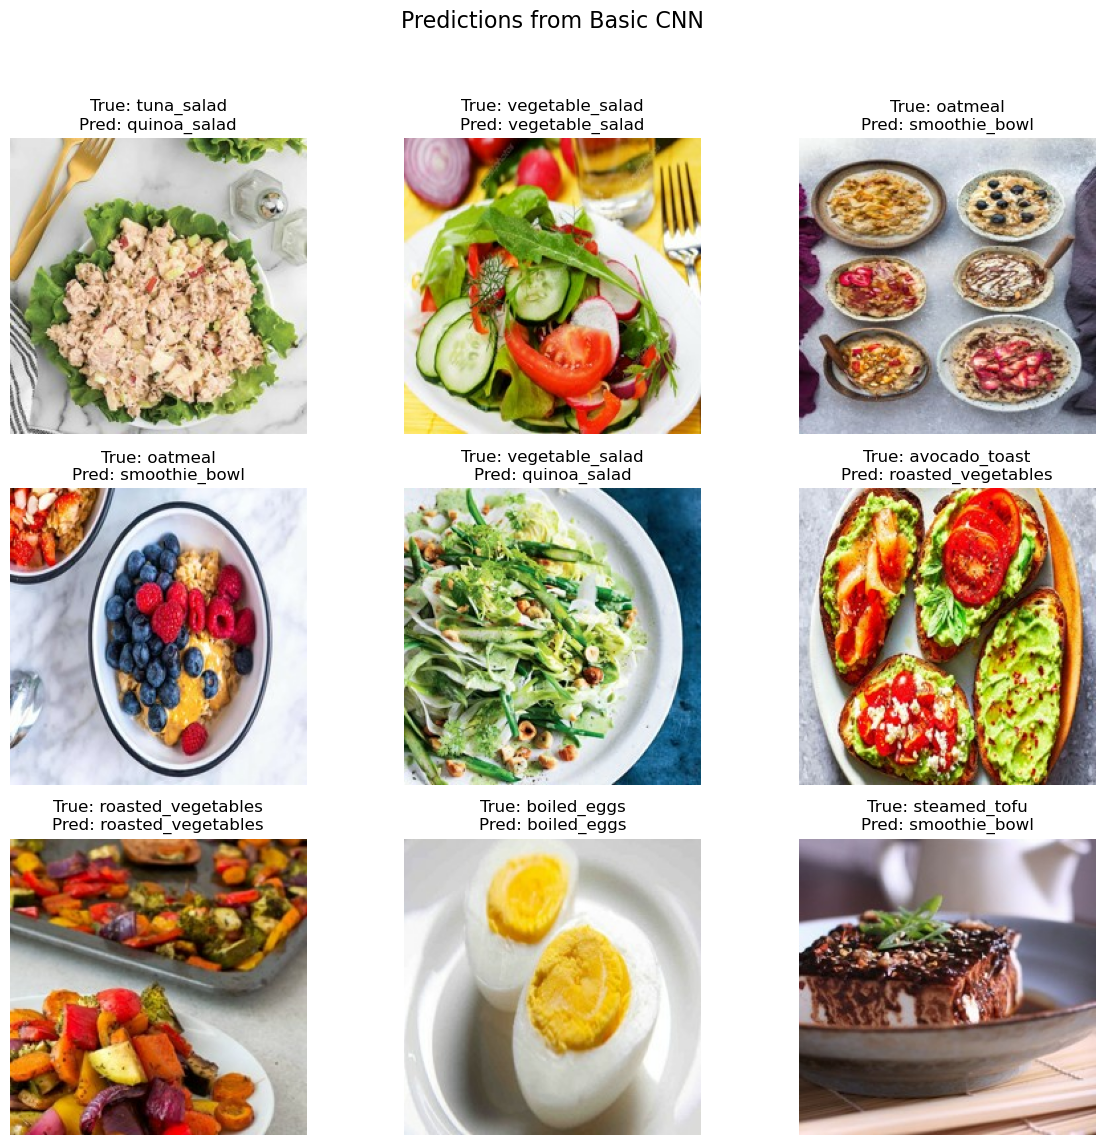

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-08-08 15:37:09.105285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


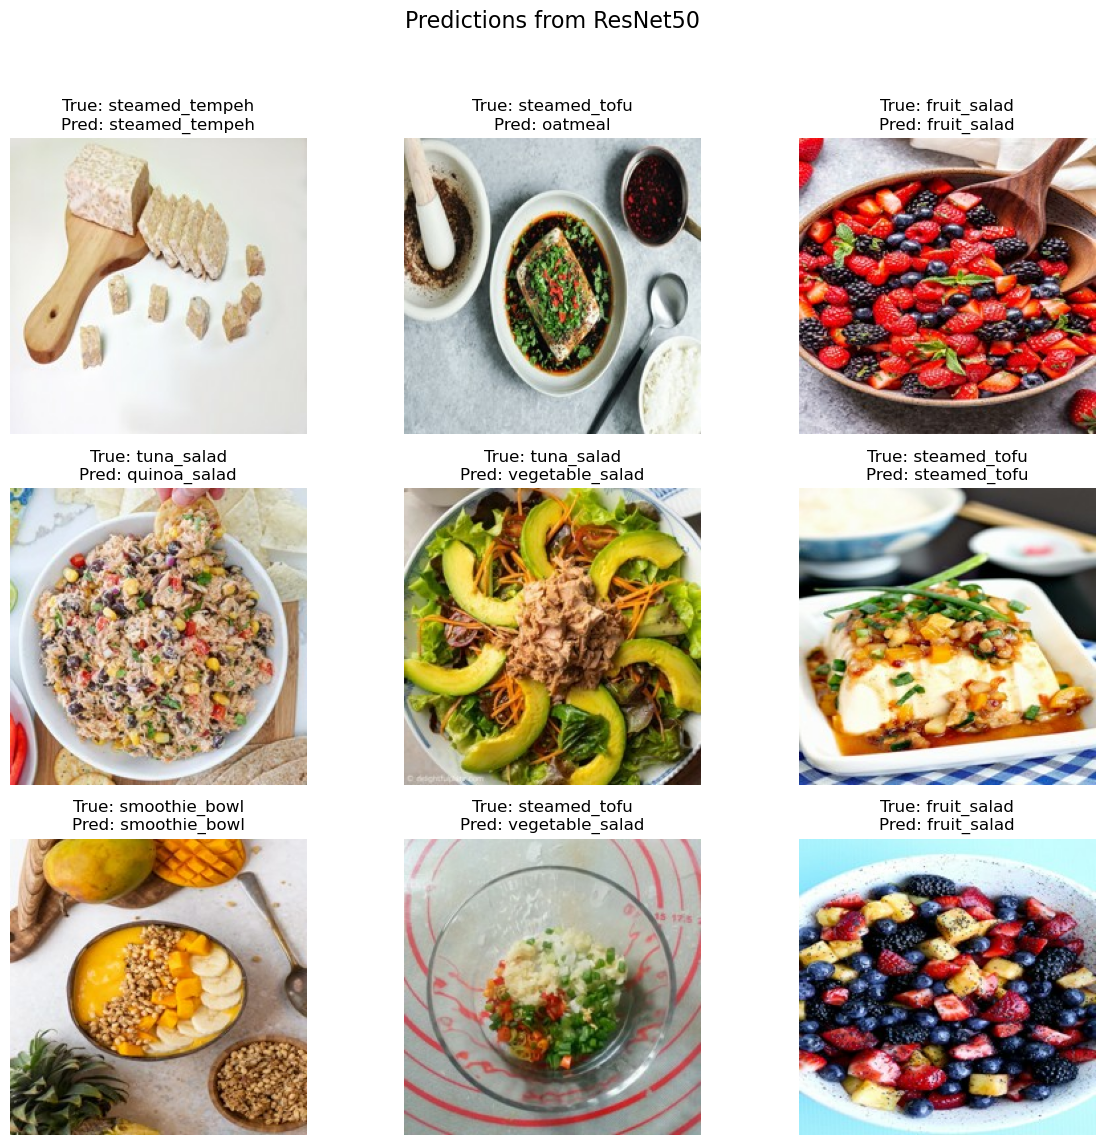

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-08-08 15:37:11.807839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


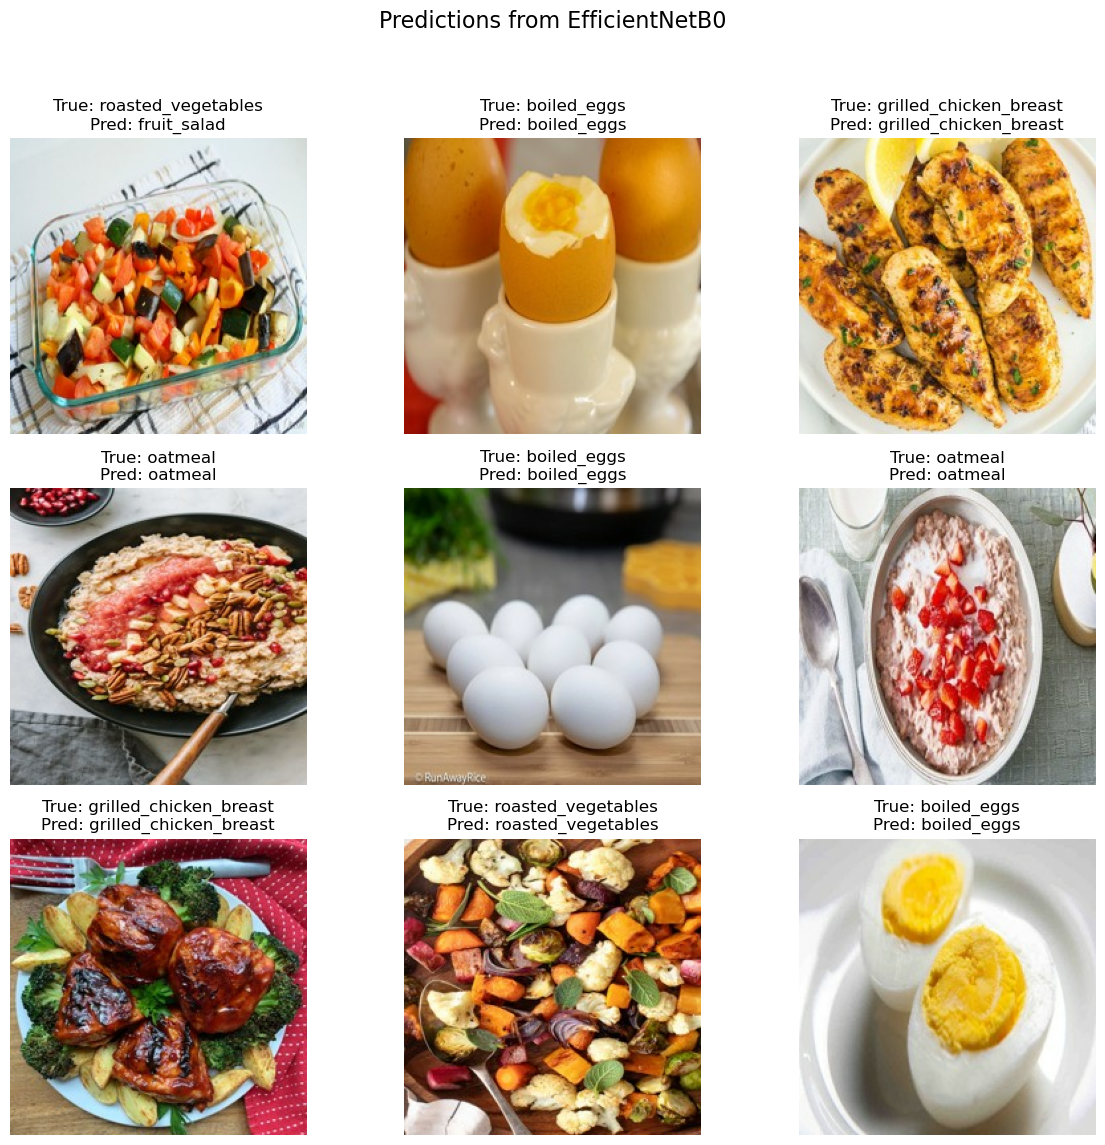

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step


2025-08-08 15:37:13.380791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


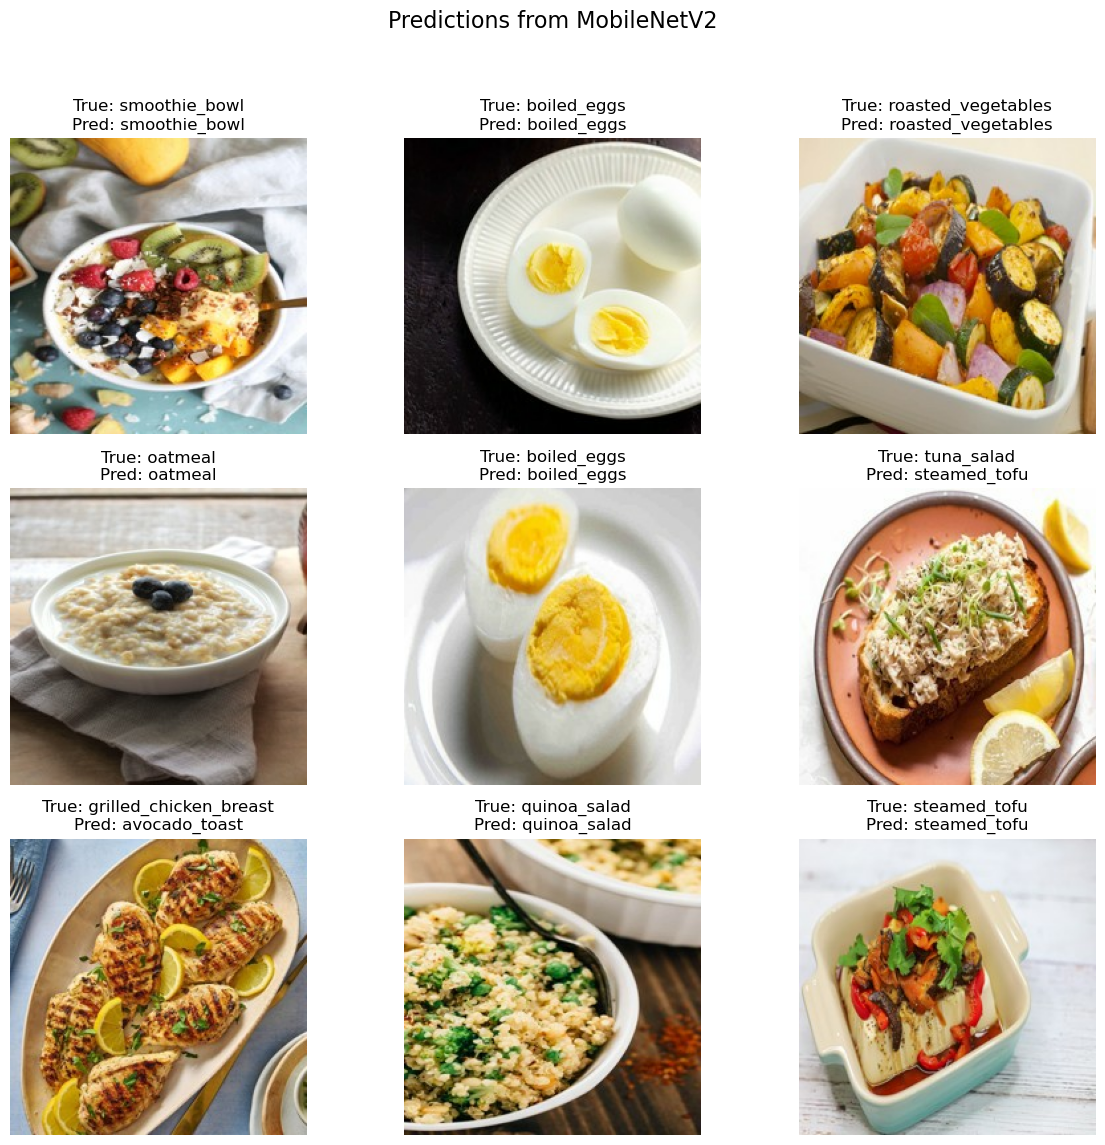

In [21]:
# Visualize predictions from Basic CNN
visualize_predictions(basic_model, val_ds, class_names, title="Basic CNN")

# Visualize predictions from ResNet50
visualize_predictions(trained_models["ResNet50"], val_ds, class_names, title="ResNet50")

# Visualize predictions from EfficientNetB0
visualize_predictions(trained_models["EfficientNetB0"], val_ds, class_names, title="EfficientNetB0")

# Visualize predictions from MobileNetV2
visualize_predictions(trained_models["MobileNetV2"], val_ds, class_names, title="MobileNetV2")
